In [154]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from seaborn import pairplot

In [166]:
## read the dataframe containing out final data
df = pd.read_csv("sec_finalized_data.csv")
df.columns

Index(['Filename', 'Year', 'loan_amount', 'Country', 'Region', 'Elec', 'GDPpC',
       'Lit', 'Gini', 'Stability', 'Population', 'Area (sq. mi.)', 'label0',
       'label1', 'label2', 'label3', 'label4', 'label5', 'label6', 'label7',
       'label8', 'label9', 'label10', 'final_label'],
      dtype='object')

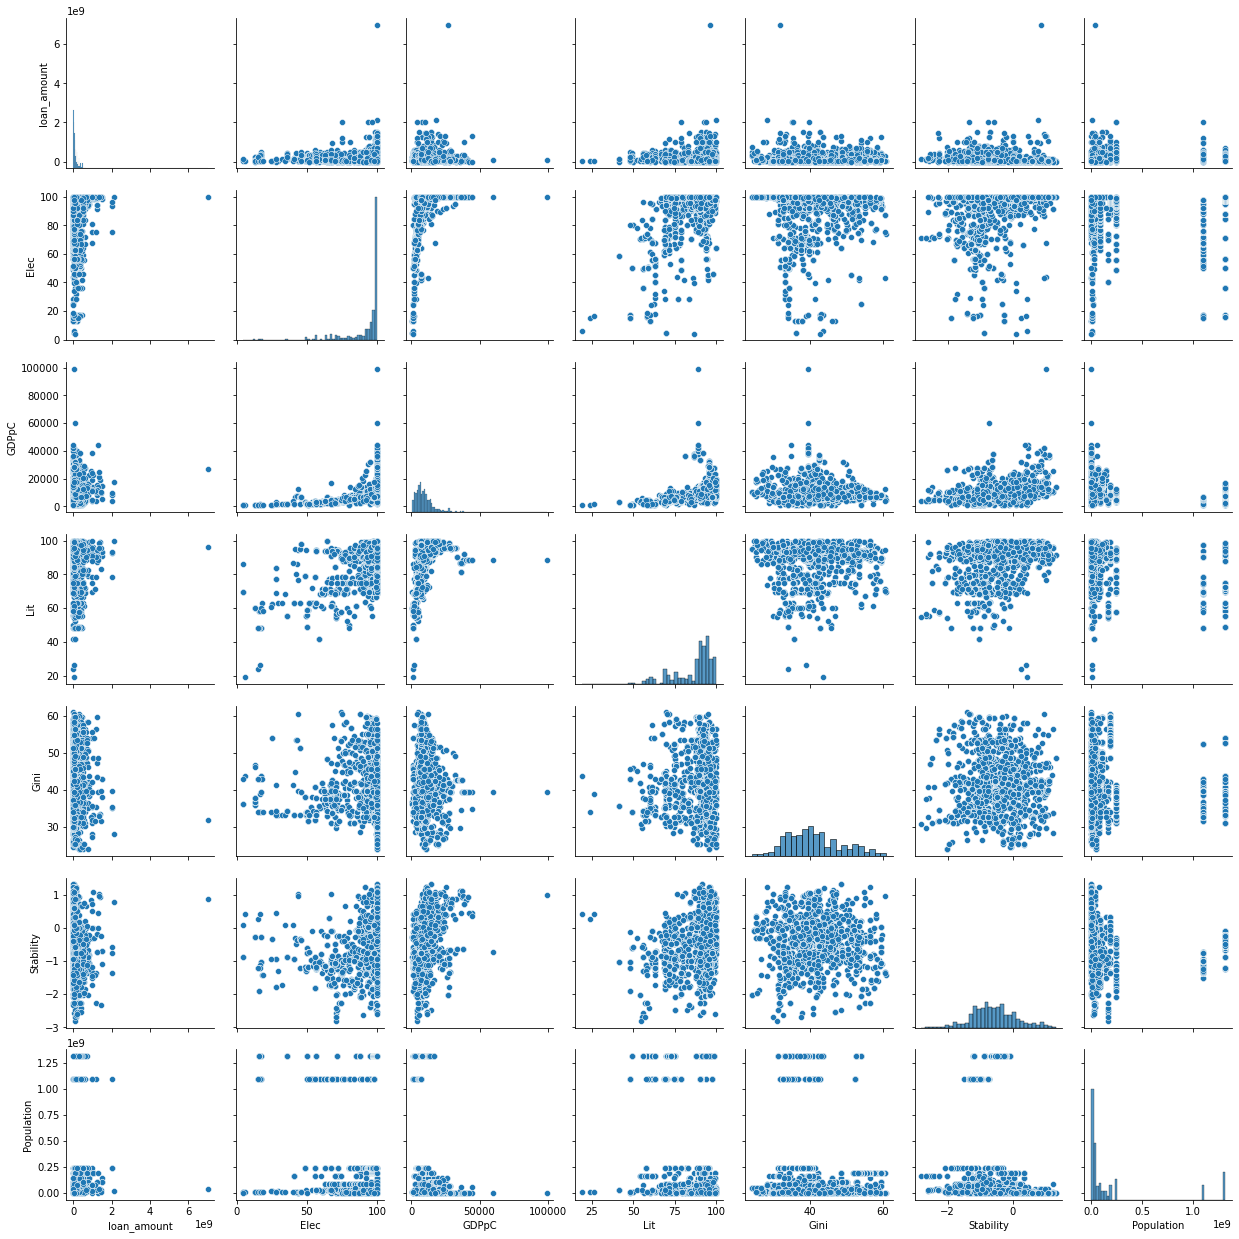

In [167]:
features1 = ['loan_amount', 'Elec', 'GDPpC','Lit', 'Gini', 'Stability', 'Population']
pairplot(df[features1])


As we can see from above, many features have distributions which are skew to one side. We may need logarithm to smooth the distributions.

In [168]:
## take logarithms of selected columns
def log(df,cols = ['loan_amount']):
    n_df = df.copy()
    columns = df[cols].to_numpy()
    log_col = np.round(np.log(columns),6)
    n_cols=[]
    for col in cols:
        n_cols.append('log_'+col)
    n_df[n_cols] = log_col
    return n_df, n_cols

From the distribution pictures above, we choose the following features to smooth using logarithm.

In [169]:

features =['loan_amount','Elec','GDPpC','Lit','Population']

log_df,log_features = log(df,features)
del df

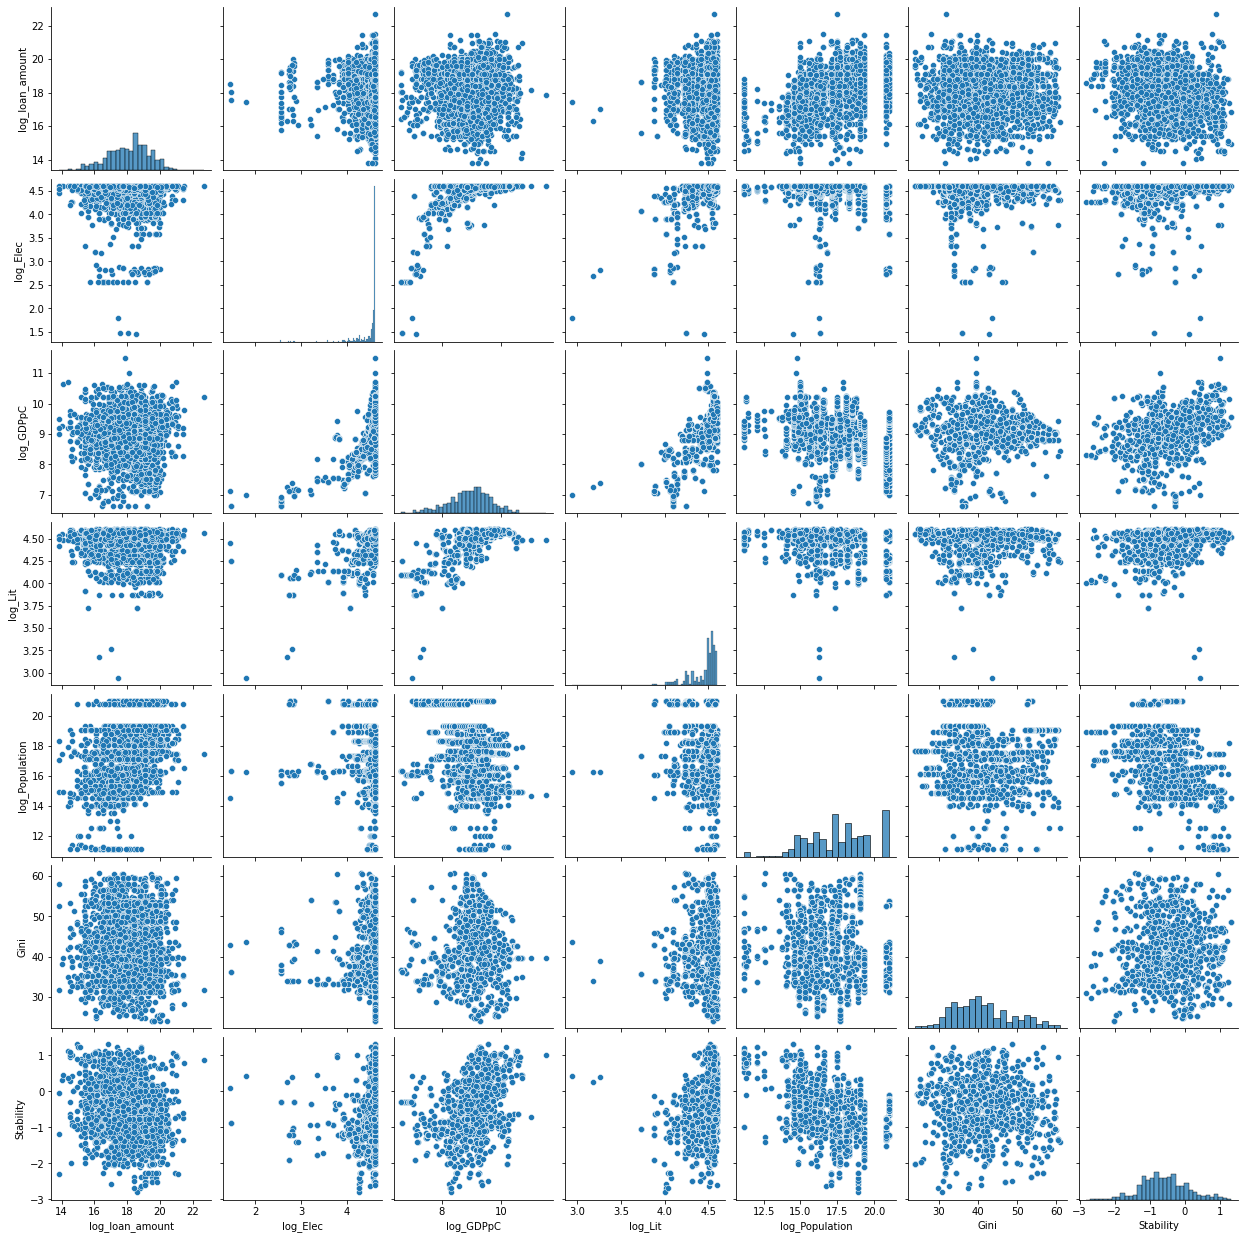

In [170]:
log_features.append('Gini')
log_features.append( 'Stability')
pairplot(log_df[log_features])

Also, there are some outersliers for each features, we need to get rid of these noises before establishing our models.

In [171]:
## This function is defined to delete outerliers and scaler the data
def preprocess(df, thresholds_dic):
    t0 = pd.Series([True]* len(df.index) ,index = df.index)
    features = list(thresholds_dic.keys())
    i = 0
    for feature in features:
        t = (df[feature] >= thresholds_dic[feature][0])&(df[feature] <= thresholds_dic[feature][1])
        t0 = t & t0
        i+=1

    n_df =df[t0]
    X = n_df[features].to_numpy()
    scaler = StandardScaler()
    scale_X = scaler.fit_transform(X)
    n_df[features] = scale_X
    return n_df

In [172]:
thresholds_dic = {"log_loan_amount" : [15,21],"log_GDPpC" :[7,10.5],"Stability":[-2,1]}
n_df = preprocess(log_df, thresholds_dic)
n_df.sample()
del log_df

<ipython-input-171-71dd276a1668>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_df[features] = scale_X
/Applications/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


Because absolute loan amount is hard to predict, it maybe effected by many features. Limited by the data we have, it is more reasonable to discretize the loan amounts to several classes, and predict the classes using the features we have.

In [161]:
## The function below discretizes values of a column from a dataframe. Before discretizing, 
## the largest outerliers are treated as one bin and the smallest outerliers are groupped to another bin
## This function adds a new column to orginal df and a list of the boundary of the bins, a is in category i if boundary[i] <= a < boundary[i+1]

def discretize(df,col,bins,upper_perc = 0.02,lower_perc = 0.02):
    boundary_list = []
    sorted_df = df.sort_values(by = col, ascending= True)
    sorted_column = sorted_df[col].to_numpy()
    dis_column = np.zeros(len(sorted_column))

    upper_index = int(len(sorted_column) - 1 - np.floor(len(sorted_column)* upper_perc))
    lower_index = int(np.floor(len(sorted_column) * lower_perc))
    mx = sorted_column[upper_index]
    mn = sorted_column[lower_index]
    r=round((mx - mn)/bins,2)
    for i in range(bins + 1):
        if i == 0:
            boundary_list.append(mn)
        elif i < bins :
            boundary_list.append(boundary_list[i-1]+r)
        elif i == bins:
            boundary_list.append(mx)
        
    k = 0
    for j in range(len(sorted_column)):
        if sorted_column[j] > boundary_list[bins]:
            dis_column[j] = bins + 1

        elif sorted_column[j] == boundary_list[bins]:
            dis_column[j] = bins

        else:   
            if sorted_column[j] >= boundary_list[k]:
                k += 1
            dis_column[j] = k

    sorted_df['discretized_'+col] = dis_column

    return sorted_df, boundary_list

In [173]:
## here we discretize the loan amounts
num_bin_loan = 10
discrete_df, a = discretize(n_df,col ="log_loan_amount", bins = num_bin_loan, upper_perc = 0.02 , lower_perc = 0.02 )

del n_df


Below is the number of loans in each class. The higher the class number is, the larger the loan amount is.

In [174]:

discrete_df.value_counts('discretized_log_loan_amount')

discretized_log_loan_amount
7.0     392
8.0     370
5.0     319
6.0     295
4.0     264
9.0     234
3.0     169
10.0    159
1.0     109
2.0     106
11.0     49
0.0      23
dtype: int64

## Next we will feed these data into our classification model. Here we choose support vector machine to classify the class of loan amount depending on all kinds of features.

First, we define some measures for measuring the accuracy of our classification.
The 'l1_metric' below is computing the l1 distance between the predict and the true vector. The larger the number is, the worse the model is.
The 'soft_accuracy_score' is similar to accuracy score, but with some tolerance of small errors. If the predicted class and the true class only differ by k, then it is viewed correctly predicted.

In [175]:

def l1_metric(y,y_pred):
    sum = abs(y-y_pred).sum()
    return sum/len(y)
    
def soft_accuracy_score(y,y_pred,k = 0):
    sum = 0
    sum = (abs(y-y_pred) <= k).sum()
    return sum/len(y)

Below is the support vector machine models with several parameter choices.

In [178]:
def muti_svm(dfs,pred_feature,conti_features, kernel = 'rbf',c=1,degree = 3):
    dic = []
    X_train = dfs[0][conti_features].to_numpy()
    y_train = dfs[0][pred_feature].to_numpy()
    X_val = dfs[1][conti_features].to_numpy()
    y_val = dfs[1][pred_feature].to_numpy()

    classifier = SVC(C = c,kernel = kernel,degree = degree)
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_val)
    dic.append( accuracy_score(y_val,y_pred))
    dic.append( soft_accuracy_score(y_val,y_pred,1))
    dic.append( l1_metric(y_val,y_pred))
    dic.append( f1_score(y_val,y_pred, average ='micro'))
    return dic   
    

In [87]:
## train_test split
train_df, test_df= train_test_split(discrete_df, test_size = 0.2, random_state = 100, stratify= discrete_df['discretized_log_loan_amount'])

## Hyperparameter Tunings
Below are different choices of parameters. Different features to include, different parameters to use in the SVM model.

In [176]:
## possible models to compare
## model1: only use stability and log_GDP, and hot vector of sector information, and log_population group.
## model2: add all possible features
       
model1 = ['Stability','log_GDPpC', 'log_Population','label0',
       'label1', 'label2', 'label3', 'label4', 'label5', 'label6', 'label7',
       'label8', 'label9', 'label10']
       
model2 = ['Stability','log_GDPpC', 'log_Population','log_Elec','log_Lit','Gini', 'label0',
       'label1', 'label2', 'label3', 'label4', 'label5', 'label6', 'label7',
       'label8', 'label9', 'label10']
models = ['baseline', model1, model2]
       
## two choices of kernel rbf and linear kernel
kernels = ['linear','rbf','poly']


In [179]:
## cross-validation to find the best models
num_splits= 5
accuracies = np.zeros((num_splits,len(models),len(kernels),4))

kfold = StratifiedKFold(n_splits= num_splits, shuffle=True,random_state=100)
i = 0
for train_index, val_index in kfold.split(train_df, train_df['discretized_log_loan_amount']):
    train_train_df = train_df.iloc[train_index]
    val_df = train_df.iloc[val_index]
    
    dfs = [train_train_df, val_df]
    # print(dfs[0].sample(1))
    ## baseline model: predict the most frequent class of loans for all training data.
    y_base_pred =np.ones(len(val_df.index))*( train_train_df['discretized_log_loan_amount'].value_counts(sort = True).index[0])
    y_val = val_df['discretized_log_loan_amount'].to_numpy()
    base_accuracy = np.zeros(4)
    
    base_accuracy[0] =accuracy_score(y_val,y_base_pred)
    base_accuracy[1]= soft_accuracy_score(y_val,y_base_pred,1)
    base_accuracy[2]=l1_metric(y_val,y_base_pred)
    base_accuracy[3]=f1_score(y_val,y_base_pred, average ='micro')
    accuracies[i,0,:] = np.broadcast_to(base_accuracy,(len(kernels),4))
   
    j = 0
    for kernel in kernels:
        for k in range(1,len(models)):
            dic = muti_svm(dfs,'discretized_log_loan_amount',models[k], kernel)
            accuracies[i,k,j,:] = dic
        j+=1
    i+=1



    


### Compare the accuracies of differen models and choose the best model.


<ipython-input-180-51914809b88f>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


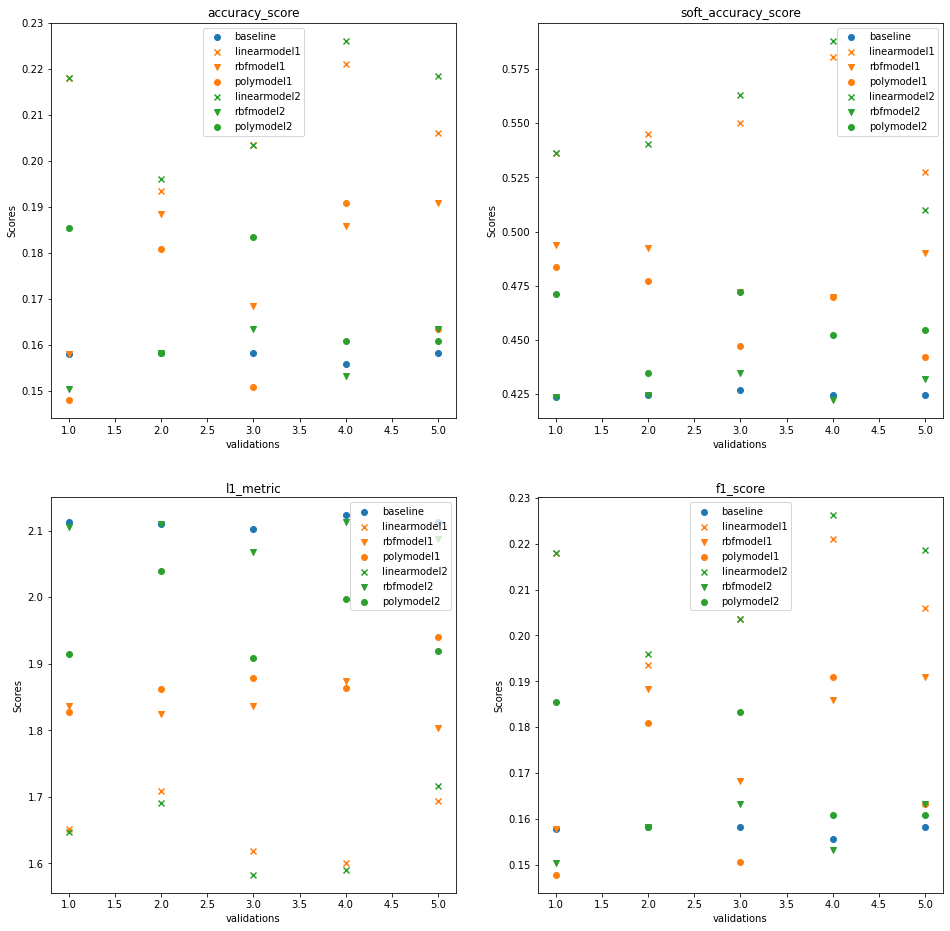

In [180]:
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','k','y']
measures_list =['accuracy_score','soft_accuracy_score','l1_metric','f1_score']

def compare_accuracies(accuracies):
    f,axes = plt.subplots(2,2,figsize = (16,16))
    i = 0
    for measure in measures_list:
        for j  in range(len(models)):
            if j == 0:
                axes[i//2][i%2].scatter(range(1,num_splits+1), accuracies[:,0,0,i],label = 'baseline',color = colors[j])
            else:
                k = 0
                markers = ['x','v', 'o']
                for kernel in kernels:
                    axes[i//2][i%2].scatter(range(1,num_splits+1), accuracies[:,j,k,i],label = kernel + 'model'+str(j),color = colors[j],marker = markers[k])
                    k+=1
            j+=1
        axes[i//2][i%2].set_title(measure)
        axes[i//2][i%2].set_xlabel('validations')
        axes[i//2][i%2].set_ylabel('Scores')  
        axes[i//2][i%2].legend()
        i+=1
    f.show()
                

compare_accuracies(accuracies)




From the accuracies pictures above, the best model is the linear SVM model with all features included.
Next we will check how the model performs on test set.

In [181]:
## According to the above scores, we are going to use model2 with linear kernel. And to see the model's performance on test sets.
svm_classifier = SVC(C=1, kernel ='linear')
X_train = train_df[model2].to_numpy()
y_train = train_df['discretized_log_loan_amount'].to_numpy()
X_test = test_df[model2].to_numpy()
y_test = test_df['discretized_log_loan_amount'].to_numpy()
svm_classifier.fit(X_train, y_train)

y_train_pred = svm_classifier.predict(X_train)
y_test_pred = svm_classifier.predict(X_test)

train_accuracies = [accuracy_score(y_train,y_train_pred),soft_accuracy_score(y_train,y_train_pred,1),l1_metric(y_train,y_train_pred),f1_score(y_train,y_train_pred,average ='micro')]
test_accuracies = [accuracy_score(y_test,y_test_pred),soft_accuracy_score(y_test,y_test_pred,1),l1_metric(y_test,y_test_pred),f1_score(y_test,y_test_pred,average = 'micro')]
print("Different measures on training set:", train_accuracies)
print("Different measures on test set:", test_accuracies)




Different measures on training set: [0.245605223505776, 0.55700652938222, 1.5991963837267704, 0.245605223505776]
Different measures on test set: [0.21887550200803213, 0.5502008032128514, 1.6927710843373494, 0.2188755020080321]


### here we can see that the model is not working well even on training set, which means the data we choose may be not explainable to the loan amounts.